<a href="https://colab.research.google.com/github/Lucky-Millare/CSST106-CS4B/blob/main/Feature-Extraction-Machine-Problem%233/4B_MILLARE_MP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Surf Dependencies**

In [1]:
# Uninstall existing OpenCV packages
!pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless

# Install system dependencies
!apt-get update
!apt-get install -y build-essential cmake git pkg-config libjpeg-dev libtiff5-dev \
    libjasper-dev libpng-dev libavcodec-dev libavformat-dev libswscale-dev \
    libv4l-dev libxvidcore-dev libx264-dev libgtk-3-dev libatlas-base-dev gfortran \
    python3-dev

# Clone OpenCV and OpenCV contrib
!git clone https://github.com/opencv/opencv.git
!git clone https://github.com/opencv/opencv_contrib.git

# Create a build directory
!mkdir -p opencv/build
%cd opencv/build

# Configure the build with non-free modules
!cmake -DOPENCV_EXTRA_MODULES_PATH=../../opencv_contrib/modules -DOPENCV_ENABLE_NONFREE=ON -D CMAKE_BUILD_TYPE=RELEASE -D CMAKE_INSTALL_PREFIX=/usr/local ..

# Build OpenCV (this may take some time)
!make -j4

# Install the built OpenCV
!make install

Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Successfully uninstalled opencv-python-4.10.0.84
Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Successfully uninstalled opencv-contrib-python-4.10.0.84
Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Successfully uninstalled opencv-python-headless-4.10.0.84
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 htt

# **Machine Problem No. 3: Feature Extraction and Object Detection**

# Import Libraries

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Step 1: Load Image

In [3]:
image1_path = '/content/drive/MyDrive/image.jpeg'
image2_path = '/content/drive/MyDrive/image.jpeg'

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

Convert to grayscale

In [4]:
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

### Step 2: Extract Keypoints and Descriptors Using SIFT, SURF, and ORB

In [5]:
# Initialize SIFT
sift = cv2.SIFT_create()


# Detect keypoints and descriptors using SIFT
keypoints_sift1, descriptors_sift1 = sift.detectAndCompute(gray1, None)
keypoints_sift2, descriptors_sift2 = sift.detectAndCompute(gray2, None)

# Initialize SURF
surf = cv2.xfeatures2d.SURF_create()

# Detect keypoints and descriptors using SURF
keypoints_surf1, descriptors_surf1 = surf.detectAndCompute(gray1, None)
keypoints_surf2, descriptors_surf2 = surf.detectAndCompute(gray2, None)

# Initialize ORB
orb = cv2.ORB_create()

# Detect keypoints and descriptors using ORB
keypoints_orb1, descriptors_orb1 = orb.detectAndCompute(gray1, None)
keypoints_orb2, descriptors_orb2 = orb.detectAndCompute(gray2, None)

### Step 3: Feature Matching with Brute-Force and FLANN

In [8]:
# Brute-Force Matcher for SIFT and SURF (use NORM_L2 for these floating-point descriptors)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_sift = bf.match(descriptors_sift1, descriptors_sift2)
matches_sift = sorted(matches_sift, key=lambda x: x.distance)

matches_surf = bf.match(descriptors_surf1, descriptors_surf2)
matches_surf = sorted(matches_surf, key=lambda x: x.distance)

# Brute-Force Matcher for ORB (use NORM_HAMMING for binary descriptors)
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches_orb = bf_orb.match(descriptors_orb1, descriptors_orb2)
matches_orb = sorted(matches_orb, key=lambda x: x.distance)

# FLANN Matcher (for SIFT, SURF, and ORB with adjustments)
index_params_sift = dict(algorithm=1, trees=5) # Algorithm 1 (FLANN_INDEX_KDTREE) is appropriate for SIFT and SURF
index_params_surf = dict(algorithm=1, trees=5) # Algorithm 1 (FLANN_INDEX_KDTREE) is appropriate for SIFT and SURF
index_params_orb = dict(algorithm=6,  # Algorithm 6 is FLANN_INDEX_LSH, suitable for ORB
                    table_number=6,  # 12
                    key_size=12,     # 20
                    multi_probe_level=1)  # 2


search_params = dict(checks=50)

flann_sift = cv2.FlannBasedMatcher(index_params_sift, search_params) # create separate FLANN matchers for each feature type
flann_surf = cv2.FlannBasedMatcher(index_params_surf, search_params) # create separate FLANN matchers for each feature type
flann_orb = cv2.FlannBasedMatcher(index_params_orb, search_params) # create separate FLANN matchers for each feature type

matches_flann_sift = flann_sift.knnMatch(descriptors_sift1, descriptors_sift2, k=2) # use corresponding matcher
matches_flann_surf = flann_surf.knnMatch(descriptors_surf1, descriptors_surf2, k=2) # use corresponding matcher
matches_flann_orb = flann_orb.knnMatch(descriptors_orb1, descriptors_orb2, k=2)   # use corresponding matcher

# Apply ratio test for FLANN matcher (Lowe's ratio test)
good_matches_sift = []
good_matches_surf = []
good_matches_orb = []
for m, n in matches_flann_sift:
    if m.distance < 0.75 * n.distance:
        good_matches_sift.append(m)

for m, n in matches_flann_surf:
    if m.distance < 0.75 * n.distance:
        good_matches_surf.append(m)

for m, n in matches_flann_orb:
    if m.distance < 0.75 * n.distance:
        good_matches_orb.append(m)

### Step 4: Image Alignment Using Homography

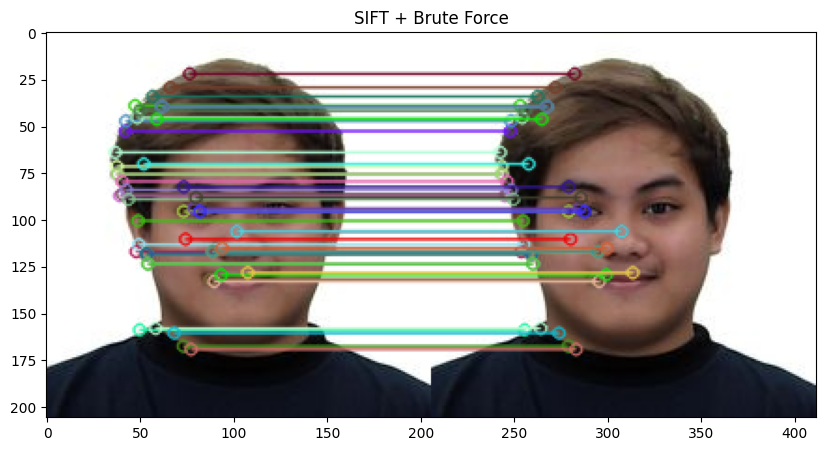

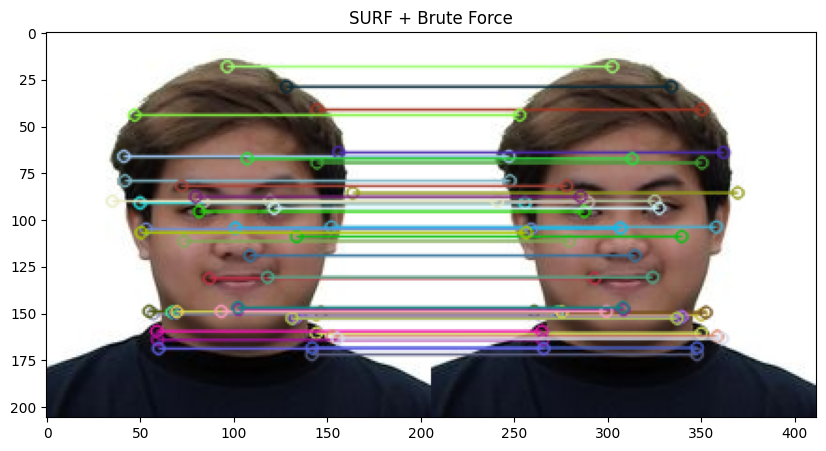

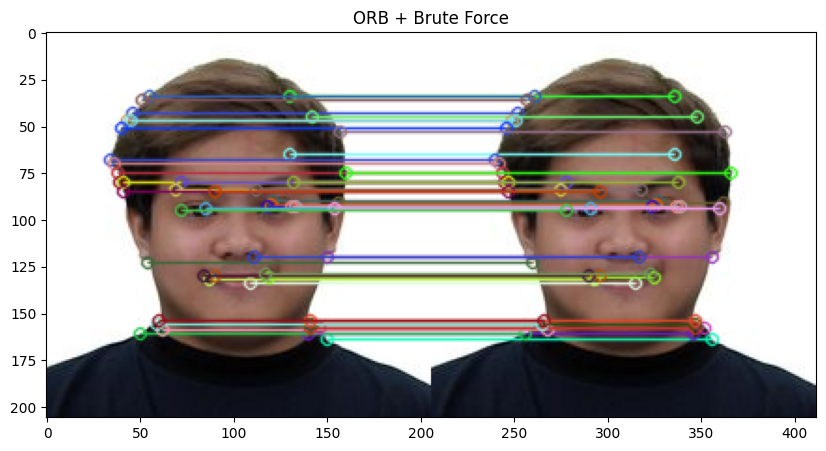

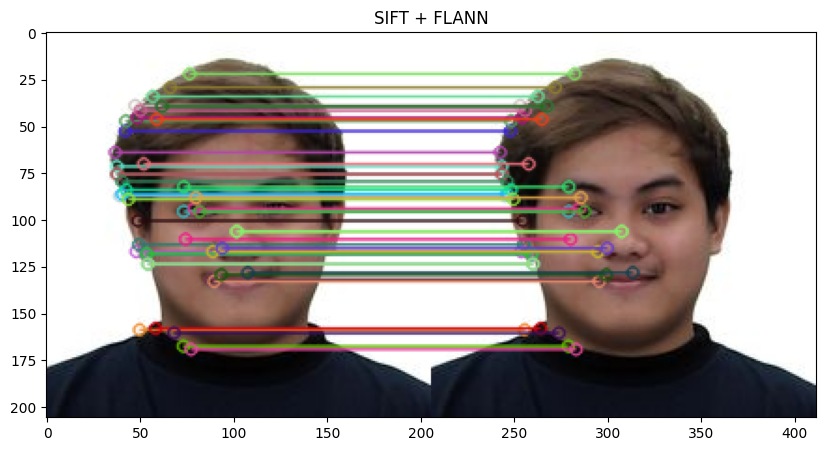

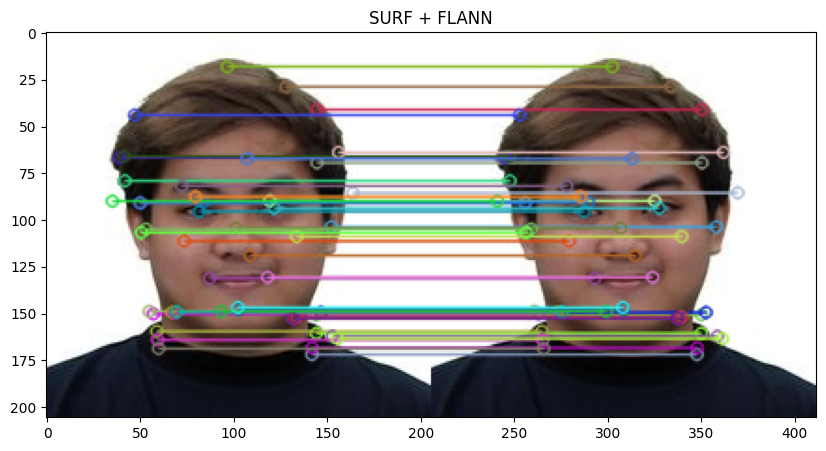

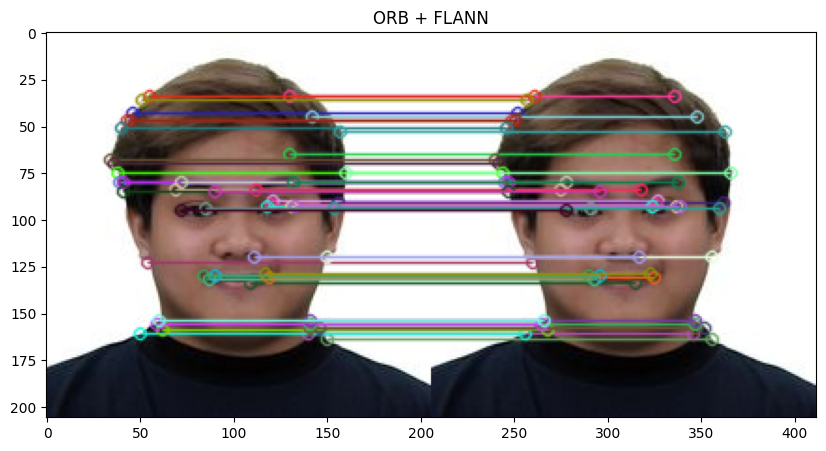

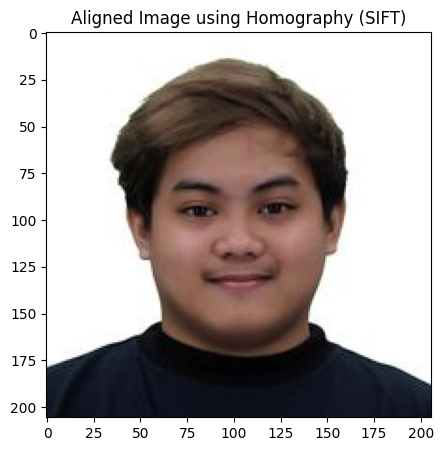

True

In [9]:
# Use SIFT keypoints to compute homography (or you can change this to SURF or ORB)
src_pts = np.float32([keypoints_sift1[m.queryIdx].pt for m in good_matches_sift]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_sift2[m.trainIdx].pt for m in good_matches_sift]).reshape(-1, 1, 2)

# Find the homography matrix
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp image1 to align with image2
h, w = image1.shape[:2]
aligned_image = cv2.warpPerspective(image1, M, (w, h))

# Display Matches for each Method
def display_matches(title, img1, kp1, img2, kp2, matches):
    result_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.show()

# Display Matches for SIFT, SURF, and ORB
display_matches('SIFT + Brute Force', image1, keypoints_sift1, image2, keypoints_sift2, matches_sift)
display_matches('SURF + Brute Force', image1, keypoints_surf1, image2, keypoints_surf2, matches_surf)
display_matches('ORB + Brute Force', image1, keypoints_orb1, image2, keypoints_orb2, matches_orb)

# Display FLANN Matches
display_matches('SIFT + FLANN', image1, keypoints_sift1, image2, keypoints_sift2, good_matches_sift)
display_matches('SURF + FLANN', image1, keypoints_surf1, image2, keypoints_surf2, good_matches_surf)
display_matches('ORB + FLANN', image1, keypoints_orb1, image2, keypoints_orb2, good_matches_orb)

# Display and Save the Aligned Image
plt.figure(figsize=(10,5))
plt.title('Aligned Image using Homography (SIFT)')
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
plt.show()

# Save the aligned image
cv2.imwrite('aligned_image.jpg', aligned_image)